# About run_sequence_analysis

This notebook creates dividies students into groups, loads their action sequences and runs the infogain analysis

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10,6
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=True)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Battery voltage, Area, Width, Separation, Wavelength, Concentration


We grab the sequences

In [3]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
pickle_in_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
all_blocked_seqs = pickle.load(pickle_in_blocked_seqs)
pickle_in_seqs.close()
pickle_in_blocked_seqs.close()

# Splitting students

## Count number of "exact" main scores in each activity (1 and 2)

In [4]:
df_all.head(6)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor
0,10127163,L,Concentration,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
1,10127163,L,Wavelength,0.0,0.0,1,1,0,0,1,1.0,NaN,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,1.0,2,1,1,1,1,1,1,4,1,1,1,1
2,10127163,L,Width,0.0,2.0,1,1,0,0,1,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
3,10127163,C,Area,2.0,2.0,1,1,0,0,1,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
4,10127163,C,Separation,2.0,2.0,1,1,0,1,2,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2,1,1,1,1,1,1,4,1,1,1,1
5,10127163,C,Battery voltage,2.0,2.0,0,1,1,0,0,NaN,NaN,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,1,1,1,1,1,1,1,4,1,1,1,1


In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index'], aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)
scores.head()

main  pre
sid      sim_index           
10127163 1           2.0  0.0
         2           3.0  3.0
10192168 1           0.0  0.0
         2           1.0  0.0
10232160 1           0.0  0.0

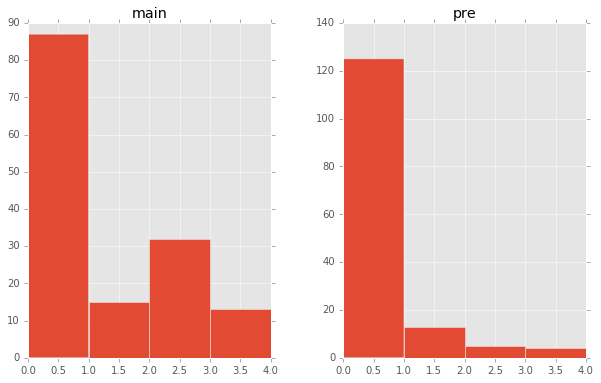

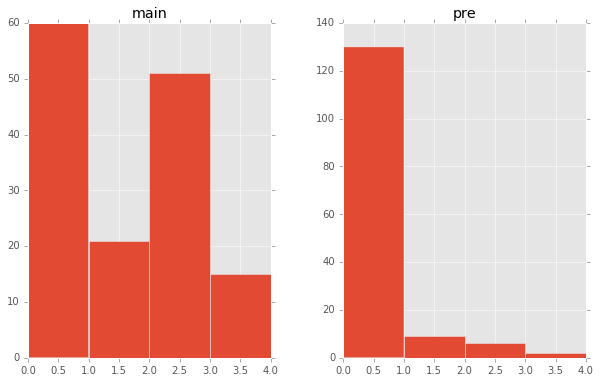

In [7]:
scores.groupby('sim_index').hist(bins=range(5));

## What if we split by those who had at least one instance of pre=2

In [8]:
def make_group(row):
    if row['pre']>0:
        if row['main']>0:
            return 'HH'
        else:
            return 'HL'
    else:
        if row['main']>0:
            return 'LH'
        else:
            return 'LL'
    
scores['group'] = scores.apply(make_group,axis=1)

In [9]:
scores.groupby(['sim_index','group']).describe()

main                                        pre              \
                count  mean   std  min  25%  50%  75%  max count  mean   std   
sim_index group                                                                
1         HH     16.0  2.12  0.89  1.0  1.0  2.0  3.0  3.0  16.0  1.81  0.83   
          HL      6.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0   6.0  1.00  0.00   
          LH     44.0  1.91  0.60  1.0  2.0  2.0  2.0  3.0  44.0  0.00  0.00   
          LL     81.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  81.0  0.00  0.00   
2         HH     16.0  2.25  0.58  1.0  2.0  2.0  3.0  3.0  16.0  1.56  0.73   
          HL      1.0  0.00   NaN  0.0  0.0  0.0  0.0  0.0   1.0  2.00   NaN   
          LH     71.0  1.86  0.64  1.0  1.0  2.0  2.0  3.0  71.0  0.00  0.00   
          LL     59.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0  59.0  0.00  0.00   

                                           
                 min  25%  50%   75%  max  
sim_index group                            
1         HH     1.0  1.0  2.0  2.25  3.0  
          HL     1.0  1.0  1.0  1.00  1.0  
          LH     0.0  0.0  0.0  0.00  0.0  
          LL     0.0  0.0  0.0  0.00  0.0  
2         HH     1.0  1.0  1.0  2.00  3.0  
          HL     2.0  2.0  2.0  2.00  2.0  
          LH     0.0  0.0  0.0  0.00  0.0  
          LL     0.0  0.0  0.0  0.00  0.0

There are many more LH than LL in activity 2, the opposite in activity 1.
The number of H_ remains the same.

### How to people transition from one group to another from activity 1 to 2?

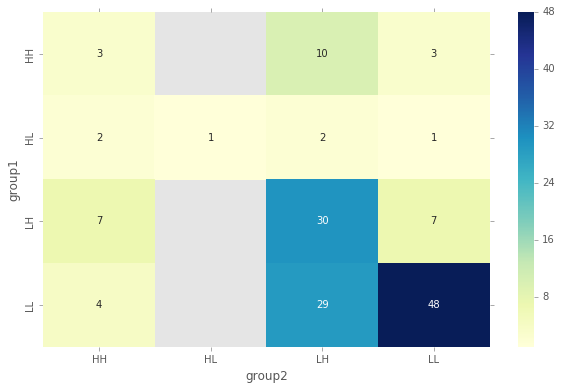

In [10]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
combogroups.drop_duplicates(inplace=True)
sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

**grey boxes have 0 students**

* Most LL students remain LL (48) and never model an exact relationship
* Many LL become LH (29)
* Many HH students remain high learning despite lower pres in 2nd activity (10)

## What if we split by learning gains from activity 1

We use the following formula for learning gains:

$gain = \frac{main-pre}{max\_score-pre}$

where max_score is the number of variables

In [11]:
max_score = len(variables)
scores['gains'] = (scores['main']-scores['pre'])/(max_score - scores['pre'])
t = scores['gains'].value_counts().sort_index()
t

-0.50      1
-0.33      2
-0.25      1
-0.20      6
 0.00    154
 0.17     30
 0.20      7
 0.25      4
 0.33     69
 0.40      4
 0.50     16
Name: gains, dtype: int64

* LL 97 students had null or negative learning gains
* LH 58 students had learning gain

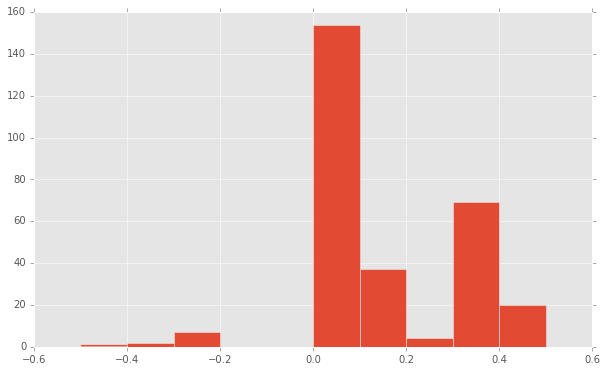

In [12]:
scores['gains'].hist()

# Todo

* run sequence analysis